In [83]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from pathlib import Path
import string
import re
import joblib
import json
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [84]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\IpoG\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [85]:
def load_doc(jsonFile):
    with open(jsonFile) as file:
        Json_data = json.loads(file.read())
    return Json_data

In [86]:
data = load_doc("F:\\Data Science Excler\\Project\\P56\\dataset\\intents.json")

In [87]:
def frame_data(feat_1,feat_2,is_pattern):
    is_pattern = is_pattern
    df = pd.DataFrame(columns=[feat_1,feat_2])
    for intent in data['intents']:
        if is_pattern:
            for pattern in intent['patterns']:
                w = pattern
                df_to_append = pd.Series([w,intent['tag']], index = df.columns)
                df = df.append(df_to_append,ignore_index=True)
        else:
            for response in intent['responses']:
                w = response
                df_to_append = pd.Series([w,intent['tag']], index = df.columns)
                df = df.append(df_to_append,ignore_index=True)
    return df

In [88]:
# users intents 
df1 = frame_data('questions','labels',True)
df1

,questions,labels
0,Leave of Absence Request,Leave_Letter_Email
1,Medical Leave of Absence Request Letter,Leave_Letter_Email
2,Annual leave application,Leave_Letter_Email
3,Maternity leave application,Leave_Letter_Email
4,Paternity leave application,Leave_Letter_Email
...,...,...
92,Formal Job Offer Letter,Job_Offer_Letter_Email
93,Developer Job Offer Letter,Job_Offer_Letter_Email
94,Internal Promotion Offer Letter,Job_Offer_Letter_Email
95,Part time to Full time Offer Letter,Job_Offer_Letter_Email


In [89]:
df1.labels.value_counts(sort=False)

Job_Invitation_Email                  5
Employee Letters                      6
Application Letter                   10
Information Request Letter           10
Business Letter                      32
Leave_Letter_Email                   14
Job_Offer_Letter_Email                5
Job Search and Networking Letters    15
Name: labels, dtype: int64

In [90]:
# Bot response
df2 = frame_data('response','labels',False)
df2.head()

,response,labels
0,"Sorry, kindly rephrase the question",confused
1,"Sorry, can't understand you",confused
2,Please give me more information,confused
3,Not sure I understand,confused
4,"Dear ABC,\n I would like to request a XXX days...",Leave_Letter_Email


In [91]:
lemmatizer = WordNetLemmatizer()

vocab = Counter()
labels = []
def tokenizer(entry):
    tokens = entry.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    tokens = [re_punc.sub('', w) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [lemmatizer.lemmatize(w.lower()) for w in tokens]
#     stop_words = set(stopwords.words('english'))
#     tokens = [w for w in tokens if not w in stop_words]
    tokens = [word.lower() for word in tokens if len(word) > 1]
    return tokens

In [92]:
def remove_stop_words(tokenizer,df,feature):
    doc_without_stopwords = []
    for entry in df[feature]:
        tokens = tokenizer(entry)
        joblib.dump(tokens,'tokens.pkl')
        doc_without_stopwords.append(' '.join(tokens))
    df[feature] = doc_without_stopwords
    return 

In [93]:
def create_vocab(tokenizer,df,feature):
    for entry in df[feature]:
        tokens = tokenizer(entry)   
        vocab.update(tokens)
    joblib.dump(vocab,'vocab.pkl')
    return 

In [94]:
create_vocab(tokenizer,df1,'questions')
remove_stop_words(tokenizer,df1,'questions')

In [95]:
print(vocab.most_common(20))

[('letter', 50), ('application', 19), ('for', 19), ('leave', 14), ('request', 11), ('email', 11), ('of', 10), ('to', 9), ('information', 9), ('employee', 7), ('inquiry', 7), ('interview', 7), ('job', 7), ('offer', 6), ('absence', 4), ('the', 4), ('family', 4), ('on', 4), ('thank', 4), ('you', 4)]


In [96]:
vocab_size = len(vocab)
vocab_size

156

In [97]:
df1

,questions,labels
0,leave of absence request,Leave_Letter_Email
1,medical leave of absence request letter,Leave_Letter_Email
2,annual leave application,Leave_Letter_Email
3,maternity leave application,Leave_Letter_Email
4,paternity leave application,Leave_Letter_Email
...,...,...
92,formal job offer letter,Job_Offer_Letter_Email
93,developer job offer letter,Job_Offer_Letter_Email
94,internal promotion offer letter,Job_Offer_Letter_Email
95,part time to full time offer letter,Job_Offer_Letter_Email


In [98]:
test_list = list(df1.groupby(by='labels',as_index=False).first()['questions'])
test_list

['transfer application letter',
 'apology letter',
 'employee letter',
 'request for cheque book information letter',
 'quick follow up email for conference',
 'casual interview',
 'formal job offer letter',
 'leave of absence request']

In [99]:
test_index = []
for i,_ in enumerate(test_list):
    idx = df1[df1.questions == test_list[i]].index[0]
    test_index.append(idx)
test_index

[52, 14, 46, 62, 72, 87, 92, 0]

In [100]:
train_index = [i for i in df1.index if i not in test_index]

In [101]:
' '.join(list(vocab.keys()))

'leave of absence request medical letter annual application maternity paternity casual sick due to the illness family member required death in personal for day email half my wedding bereavement on demise relation with memberfriend emergency apology thank you note charitable contribution team leadership project business candidate rejection congratulation resignation notification excuse documentation advanced notice formal sickness offer assistance employee sample complimentary handling reply an change working hour company bonus new vacation policy employment verification template current past departure moving research inquiry real estate after interview congressional credit explanation report appreciation semiformal goodbye late work mistake at salary reduction transfer job college receptionist bank manager overdue payment reminder scholarship internship graduate school librarian cheque book information requesting productservice wholesale price list meeting increment free informational 

In [102]:
def encoder(df,feature):
#     text = ' '.join(list(vocab.keys()))
    t = Tokenizer()
    entries = [entry for entry in df[feature]]
    t.fit_on_texts(entries)
    joblib.dump(t,'tokenizer_t.pkl')
    vocab_size = len(t.word_index) + 1
    entries = [entry for entry in df[feature]]
    max_length = max([len(s.split()) for s in entries])
    encoded = t.texts_to_sequences(entries)
    padded = pad_sequences(encoded, maxlen=max_length, padding='post')
    return padded, vocab_size

In [103]:
X,vocab_size = encoder(df1,'questions')

In [104]:
df_encoded = pd.DataFrame(X)

In [105]:
df_encoded['labels'] = df1.labels
df_encoded.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,labels
0,4,7,15,5,0,0,0,0,0,0,0,0,0,Leave_Letter_Email
1,58,4,7,15,5,1,0,0,0,0,0,0,0,Leave_Letter_Email
2,59,4,2,0,0,0,0,0,0,0,0,0,0,Leave_Letter_Email
3,60,4,2,0,0,0,0,0,0,0,0,0,0,Leave_Letter_Email
4,61,4,2,0,0,0,0,0,0,0,0,0,0,Leave_Letter_Email


In [106]:
for i in range(0,2):
    dt = [0]*13
    dt.append('confused')
    dt = [dt]
    pd.DataFrame(dt).rename(columns = {13:'labels'})
    df_encoded = df_encoded.append(pd.DataFrame(dt).rename(columns = {13:'labels'}),ignore_index=True)

In [107]:
df_encoded.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,labels
94,153,154,14,1,0,0,0,0,0,0,0,0,0,Job_Offer_Letter_Email
95,56,32,8,155,32,14,1,0,0,0,0,0,0,Job_Offer_Letter_Email
96,156,13,14,1,0,0,0,0,0,0,0,0,0,Job_Offer_Letter_Email
97,0,0,0,0,0,0,0,0,0,0,0,0,0,confused
98,0,0,0,0,0,0,0,0,0,0,0,0,0,confused


In [108]:
train_index.append(97)

In [109]:
test_index.append(98)

In [110]:
# df_encoded = df_encoded.append(pd.DataFrame(dt).rename(columns = {16:'labels'}),ignore_index=True)

In [111]:
from sklearn.preprocessing import LabelEncoder
lable_enc = LabelEncoder()

In [112]:
labl = lable_enc.fit_transform(df_encoded.labels)
labl

array([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5,
       5, 5, 5, 5, 6, 6, 6, 6, 6, 8, 8])

In [113]:
mapper = {}
for index,key in enumerate(df_encoded.labels):
    if key not in mapper.keys():
        mapper[key] = labl[index]
mapper

{'Leave_Letter_Email': 7,
 'Business Letter': 1,
 'Employee Letters': 2,
 'Application Letter': 0,
 'Information Request Letter': 3,
 'Job Search and Networking Letters': 4,
 'Job_Invitation_Email': 5,
 'Job_Offer_Letter_Email': 6,
 'confused': 8}

In [114]:
df2.head()

,response,labels
0,"Sorry, kindly rephrase the question",confused
1,"Sorry, can't understand you",confused
2,Please give me more information,confused
3,Not sure I understand,confused
4,"Dear ABC,\n I would like to request a XXX days...",Leave_Letter_Email


In [115]:
df2.labels = df2.labels.map(mapper).astype({'labels': 'int32'})
df2.tail()

,response,labels
91,Position \n Job title \n Your title will be Jo...,6
92,Position \n Job Title \n Your title will be Jo...,6
93,Congratulations on your new role.Your new empl...,6
94,"Dear abc,\n We are excited to announce that we...",6
95,Position \n Job Title \n Your title will be Jo...,6


In [116]:
df2.to_csv('response.csv',index=False)

In [117]:
# df2.groupby('labels').get_group(11)

In [118]:
train = df_encoded.loc[train_index]
test = df_encoded.loc[test_index]

In [119]:
X_train = train.drop(columns=['labels'],axis=1)
y_train = train.labels
X_test = test.drop(columns=['labels'],axis=1)
y_test = test.labels


In [120]:
y_train =pd.get_dummies(y_train).values
y_test =pd.get_dummies(y_test).values

In [121]:
y_train[0].shape,y_test[0].shape

((9,), (9,))

In [122]:
X_train.shape

(90, 13)

In [123]:
max_length = X_train.shape[1]
# output = len(df3.labels.unique())
output = 9

In [124]:
# def define_model(vocab_size, max_length):
#     model = Sequential()
#     model.add(Embedding(vocab_size,300, input_length=max_length))
#     model.add(Conv1D(filters=64, kernel_size=6, activation='relu'))
#     model.add(MaxPooling1D(pool_size=4))
#     model.add(Flatten())
# #     model.add(Dense(32, activation='relu'))
#     model.add(Dense(16, activation='softmax'))
    
#     # compile network
#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#     # summarize defined model
#     model.summary()
# #     plot_model(model, to_file='model.png', show_shapes=True)
#     return model

In [125]:
max_length

13

In [126]:
early_stopping = EarlyStopping(monitor='val_loss',patience=10)
checkpoint = ModelCheckpoint("model-v1.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, verbose = 1, min_delta = 0.0001)
callbacks = [early_stopping,checkpoint,reduce_lr]
    
    

In [127]:

def define_model(vocab_size, max_length):
    model = Sequential()
    model.add(Embedding(vocab_size,300, input_length=max_length))
    model.add(Conv1D(filters=64, kernel_size=4, activation='relu'))
    model.add(MaxPooling1D(pool_size=8))
    model.add(Flatten())
#     model.add(Dense(32, activation='relu'))
    model.add(Dense(9, activation='softmax'))
    
    
    # compile network
#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.compile(loss = 'categorical_crossentropy',
              # optimizer = Adam(lr=0.001),
              optimizer = 'adam',
              metrics = ['accuracy'])
    
    # summarize defined model
    model.summary()
#     plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [128]:
# define model
model = define_model(vocab_size, max_length)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 13, 300)           47100     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 10, 64)            76864     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 585       
Total params: 124,549
Trainable params: 124,549
Non-trainable params: 0
_________________________________________________________________


In [129]:
history = model.fit(X_train, y_train, epochs=500, verbose=1,validation_data=(X_test,y_test),callbacks=callbacks)

Epoch 1/500
3/3 [==============================] - 2s 197ms/step - loss: 2.1849 - accuracy: 0.2000 - val_loss: 2.1473 - val_accuracy: 0.1111

Epoch 00001: val_loss improved from inf to 2.14733, saving model to model-v1.h5
Epoch 2/500
3/3 [==============================] - 0s 30ms/step - loss: 2.0413 - accuracy: 0.4667 - val_loss: 2.1309 - val_accuracy: 0.1111

Epoch 00002: val_loss improved from 2.14733 to 2.13085, saving model to model-v1.h5
Epoch 3/500
3/3 [==============================] - 0s 25ms/step - loss: 1.9307 - accuracy: 0.4222 - val_loss: 2.1200 - val_accuracy: 0.1111

Epoch 00003: val_loss improved from 2.13085 to 2.12001, saving model to model-v1.h5
Epoch 4/500
3/3 [==============================] - 0s 31ms/step - loss: 1.8179 - accuracy: 0.4111 - val_loss: 2.1131 - val_accuracy: 0.1111

Epoch 00004: val_loss improved from 2.12001 to 2.11311, saving model to model-v1.h5
Epoch 5/500
3/3 [==============================] - 0s 34ms/step - loss: 1.7066 - accuracy: 0.4444 - val


Epoch 00037: val_loss improved from 0.75046 to 0.73999, saving model to model-v1.h5
Epoch 38/500
3/3 [==============================] - 0s 22ms/step - loss: 0.0600 - accuracy: 0.9889 - val_loss: 0.7324 - val_accuracy: 0.6667

Epoch 00038: val_loss improved from 0.73999 to 0.73242, saving model to model-v1.h5
Epoch 39/500
3/3 [==============================] - 0s 28ms/step - loss: 0.0572 - accuracy: 0.9889 - val_loss: 0.7234 - val_accuracy: 0.6667

Epoch 00039: val_loss improved from 0.73242 to 0.72342, saving model to model-v1.h5
Epoch 40/500
3/3 [==============================] - 0s 38ms/step - loss: 0.0543 - accuracy: 0.9889 - val_loss: 0.7146 - val_accuracy: 0.6667

Epoch 00040: val_loss improved from 0.72342 to 0.71458, saving model to model-v1.h5
Epoch 41/500
3/3 [==============================] - 0s 33ms/step - loss: 0.0516 - accuracy: 0.9889 - val_loss: 0.7061 - val_accuracy: 0.6667

Epoch 00041: val_loss improved from 0.71458 to 0.70612, saving model to model-v1.h5
Epoch 42/50

Epoch 74/500
3/3 [==============================] - 0s 34ms/step - loss: 0.0101 - accuracy: 1.0000 - val_loss: 0.4844 - val_accuracy: 0.7778

Epoch 00074: val_loss improved from 0.48539 to 0.48435, saving model to model-v1.h5
Epoch 75/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0097 - accuracy: 1.0000 - val_loss: 0.4832 - val_accuracy: 0.7778

Epoch 00075: val_loss improved from 0.48435 to 0.48322, saving model to model-v1.h5
Epoch 76/500
3/3 [==============================] - 0s 26ms/step - loss: 0.0092 - accuracy: 1.0000 - val_loss: 0.4825 - val_accuracy: 0.7778

Epoch 00076: val_loss improved from 0.48322 to 0.48248, saving model to model-v1.h5
Epoch 77/500
3/3 [==============================] - 0s 28ms/step - loss: 0.0088 - accuracy: 1.0000 - val_loss: 0.4823 - val_accuracy: 0.7778

Epoch 00077: val_loss improved from 0.48248 to 0.48229, saving model to model-v1.h5
Epoch 78/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0085 - accuracy: 1.00

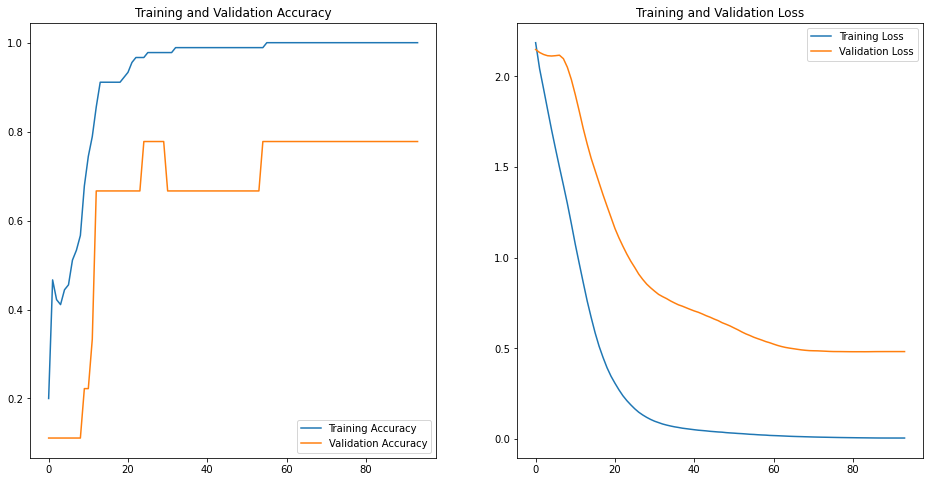

In [130]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [131]:
[np.argmax(i) for i in model.predict(X_test)][:10]

[0, 2, 1, 3, 4, 5, 6, 7, 8]

In [132]:
[np.argmax(i) for i in y_test][:10]

[0, 1, 2, 3, 4, 5, 6, 7, 8]